In [1]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

root_path = Path("/home/olivieri/exp").resolve()
src_path = root_path / "src"
sys.path.append(f"{str(src_path)}")

In [2]:
from prompter import *
from data import *
from utils import *
from model import GoogleAIStudio
from path import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

import torch
import torchvision
from torchvision.models import segmentation as segmodels
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms as transforms
import torch.nn.functional as F

# Model

In [4]:
print(torch.hub.get_dir())
print(DEVICE)

/home/olivieri/exp/data/torch_weights
cuda


In [5]:
BY_MODEL = "LRASPP_MobileNet_V3"
SPLIT_BY = "non-splitted"
IMAGE_SIZE = (520, 520)

mask_prs_path = get_mask_prs_path(BY_MODEL)
mask_prs_path

PosixPath('/home/olivieri/exp/data/VOCdevkit/VOC2012/MyAnnotations/by_model/LRASPP_MobileNet_V3/_mask_prs_')

In [6]:
WEIGHTS = segmodels.LRASPP_MobileNet_V3_Large_Weights.DEFAULT
MODEL = segmodels.lraspp_mobilenet_v3_large(weights=WEIGHTS)
MODEL.to(DEVICE)
MODEL.eval()

preprocess = WEIGHTS.transforms()

# Data

# Inference

In [7]:
img_paths_to_upload = image_UIDs[96:100]

sc_list = [get_sc(SCS_PATH / (img_path + ".jpg"), 520, center_crop=True) for img_path in img_paths_to_upload]
gt_list = [get_gt(GTS_PATH / (img_path + ".png"), CLASS_MAP, 520, center_crop=True) for img_path in img_paths_to_upload]

In [8]:
scs = torch.stack(sc_list, dim=0)
gts = torch.stack(gt_list, dim=0)
scs.shape, gts.shape

(torch.Size([4, 3, 520, 520]), torch.Size([4, 1, 520, 520]))

In [9]:
X = preprocess(scs)
logits = MODEL(X)["out"]
prs = logits.argmax(dim=1, keepdim=True).float()
assert scs.shape[2:] == gts.shape[2:] == prs.shape[2:]
prs.shape

torch.Size([4, 1, 520, 520])

In [10]:
gts_all_classes = (gts[:, 0] == torch.arange(NUM_CLASSES).to(DEVICE)[:, None, None, None]).swapaxes(0, 1)
prs_all_classes = (prs[:, 0] == torch.arange(NUM_CLASSES).to(DEVICE)[:, None, None, None]).swapaxes(0, 1)
assert prs_all_classes.shape == gts_all_classes.shape
gts_all_classes.shape

torch.Size([4, 21, 520, 520])

In [31]:
prs[3].unique()

tensor([ 0.,  2., 15.], device='cuda:0')

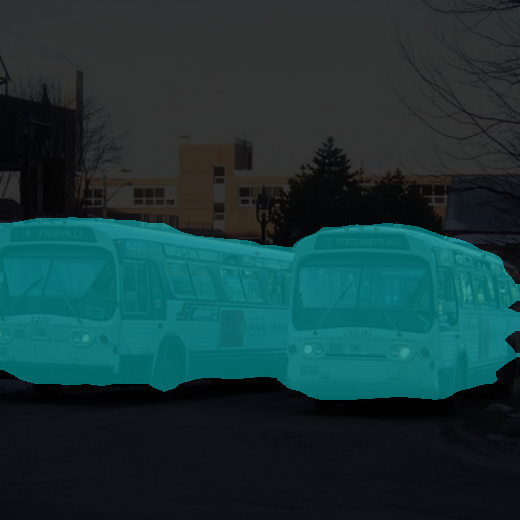

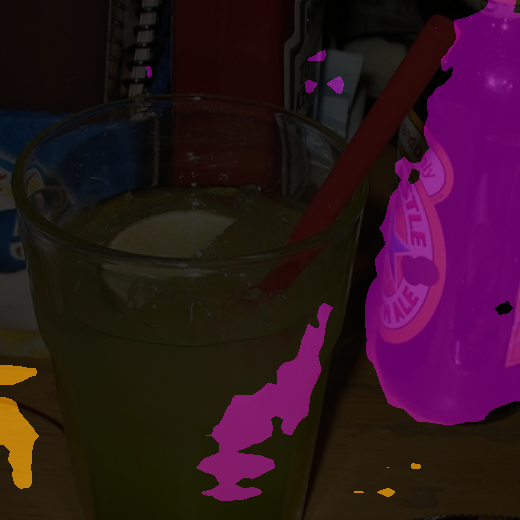

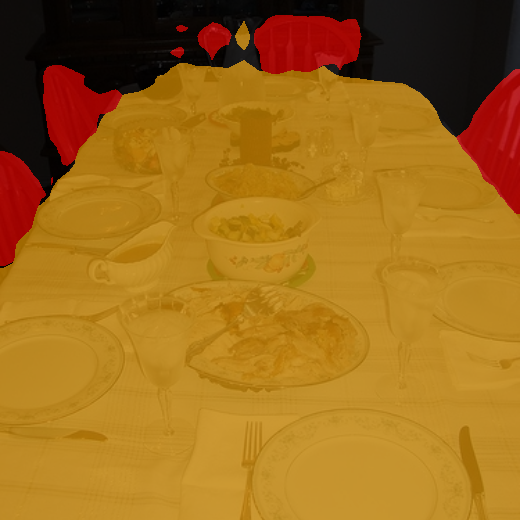

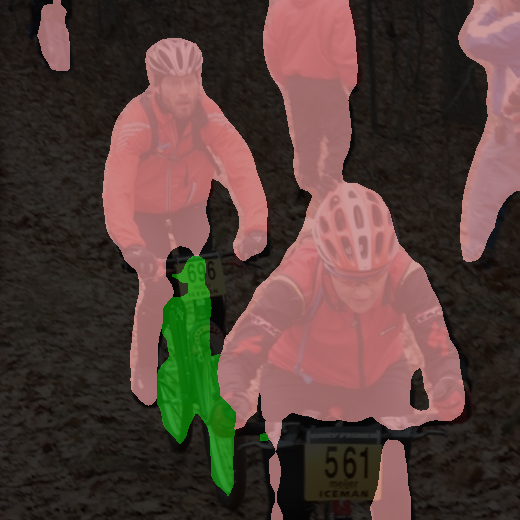

In [ ]:
for i, img_path in enumerate(img_paths_to_upload):
    pr_ovr = draw_segmentation_masks(scs[i], prs_all_classes[i], colors=list(COLOR_MAP_DICT.values()))
    display(to_pil_image(pr_ovr))
    # torchvision.utils.save_image(prs[i], mask_prs_path / f"{img_path}.png", value_range=(0, 255), normalize=True)